In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

ImportError: No module named 'sklearn'

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 10
epochs     = 100 #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "mini_competition" # "products_20" "mini_competition"
n_class = 4

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("data", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:47<00:00, 11556979.50it/s]


Finish cuda loading, time elapsed 1.7914891242980957


## Visualize model

In [7]:
print(fcn_model)
params = list(fcn_model.parameters())

DataParallel(
  (module): FCN16s(
    (pretrained_net): VGGNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

HW: Finish Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        #Return length of data
        return len(self.data)
        
    def __getitem__(self, idx):
        #Use the string in self.data to read image and label 
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img
        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        #Transpose image from (height * width * channel) to (channel * height * width)
        
        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)

        for i in range(n_class):
            target[i][label == i] = 1
            
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [8]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "val.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [9]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data[0]))
                
        loss_l.append(loss.data[0])
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        torch.save(fcn_model.state_dict(), model_path + '.pkl')

        val(epoch)

## Evaluation

In [10]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1)
    FN = np.zeros(n_class-1)
    FP = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    iou_l.append(ious)
    fscore_l.append(fscore)
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class)
    FN = np.zeros(n_class)
    FP = np.zeros(n_class)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [12]:
loss_l = []
fscore_l = []
iou_l = []
train()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch0, iter0, loss: 0.7283818125724792
epoch0, iter10, loss: 0.6878924369812012
epoch0, iter20, loss: 0.6762238144874573
epoch0, iter30, loss: 0.670185923576355
epoch0, iter40, loss: 0.6653313636779785
epoch0, iter50, loss: 0.6581562757492065
epoch0, iter60, loss: 0.6546266674995422


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Finish epoch 0, time elapsed 82.08119940757751
epoch0, pix_acc: 0.9186544552364868, meanIoU: 0.43124288152204776, IoUs: [0.44648159 0.15077214 0.69647492], recall: [0.9947122  0.99239164 0.97866561], precision: [0.44754381 0.15094662 0.70721237], fscore: [0.61733463 0.26203648 0.82108484]
epoch1, iter0, loss: 0.6538073420524597
epoch1, iter10, loss: 0.6488856673240662
epoch1, iter20, loss: 0.6465690732002258
epoch1, iter30, loss: 0.6425631642341614
epoch1, iter40, loss: 0.6361119747161865
epoch1, iter50, loss: 0.633662223815918
epoch1, iter60, loss: 0.629038393497467
Finish epoch 1, time elapsed 82.52253746986389
epoch1, pix_acc: 0.987405159065315, meanIoU: 0.7389981078850364, IoUs: [0.85383834 0.58110311 0.78205287], recall: [0.9502002  0.99162323 0.98022262], precision: [0.89383709 0.58396975 0.79459074], fscore: [0.92115728 0.73506036 0.87769884]
epoch2, iter0, loss: 0.6270663142204285
epoch2, iter10, loss: 0.6230831742286682
epoch2, iter20, loss: 0.6199941635131836
epoch2, iter30, 

epoch15, iter0, loss: 0.3630443811416626
epoch15, iter10, loss: 0.3596746027469635
epoch15, iter20, loss: 0.3559519052505493
epoch15, iter30, loss: 0.3524695336818695
epoch15, iter40, loss: 0.3499417304992676
epoch15, iter50, loss: 0.34972667694091797
epoch15, iter60, loss: 0.34413304924964905
Finish epoch 15, time elapsed 83.36136841773987
epoch15, pix_acc: 0.9968127991272524, meanIoU: 0.9076741247646565, IoUs: [0.90939789 0.91064604 0.90297845], recall: [0.9665122  0.95694651 0.97827117], precision: [0.93898425 0.94954947 0.92145967], fscore: [0.95254938 0.95323364 0.94901595]
epoch16, iter0, loss: 0.3438349962234497
epoch16, iter10, loss: 0.3418387770652771
epoch16, iter20, loss: 0.3350639045238495
epoch16, iter30, loss: 0.33410322666168213
epoch16, iter40, loss: 0.33241453766822815
epoch16, iter50, loss: 0.32758447527885437
epoch16, iter60, loss: 0.325115829706192
Finish epoch 16, time elapsed 83.43861794471741
epoch16, pix_acc: 0.9968609234234236, meanIoU: 0.9070158915438881, IoUs

epoch29, iter0, loss: 0.12953265011310577
epoch29, iter10, loss: 0.12765535712242126
epoch29, iter20, loss: 0.12476349622011185
epoch29, iter30, loss: 0.12507414817810059
epoch29, iter40, loss: 0.12203656136989594
epoch29, iter50, loss: 0.12172584980726242
epoch29, iter60, loss: 0.11942838132381439
Finish epoch 29, time elapsed 83.32538032531738
epoch29, pix_acc: 0.9969082119228603, meanIoU: 0.9071303194206354, IoUs: [0.89715177 0.91187513 0.91236405], recall: [0.92193339 0.95335052 0.94419705], precision: [0.97091004 0.95446329 0.96436409], fscore: [0.94578809 0.95390658 0.95417402]
epoch30, iter0, loss: 0.11823922395706177
epoch30, iter10, loss: 0.11617323011159897
epoch30, iter20, loss: 0.11425678431987762
epoch30, iter30, loss: 0.1126784011721611
epoch30, iter40, loss: 0.11207405477762222
epoch30, iter50, loss: 0.11370229721069336
epoch30, iter60, loss: 0.11027948558330536
Finish epoch 30, time elapsed 83.13251090049744
epoch30, pix_acc: 0.9968466269003377, meanIoU: 0.9065680846898

epoch43, iter0, loss: 0.03130420297384262
epoch43, iter10, loss: 0.031114960089325905
epoch43, iter20, loss: 0.0301815215498209
epoch43, iter30, loss: 0.030049124732613564
epoch43, iter40, loss: 0.029735947027802467
epoch43, iter50, loss: 0.02908872254192829
epoch43, iter60, loss: 0.029273077845573425
Finish epoch 43, time elapsed 83.5524730682373
epoch43, pix_acc: 0.9968388847832209, meanIoU: 0.9045526161120468, IoUs: [0.89196084 0.90518921 0.9165078 ], recall: [0.91101418 0.93054436 0.95146306], precision: [0.97708951 0.97077802 0.96145966], fscore: [0.94289567 0.9502355  0.95643524]
epoch44, iter0, loss: 0.028114410117268562
epoch44, iter10, loss: 0.027487630024552345
epoch44, iter20, loss: 0.027103807777166367
epoch44, iter30, loss: 0.02684856951236725
epoch44, iter40, loss: 0.026256727054715157
epoch44, iter50, loss: 0.025963298976421356
epoch44, iter60, loss: 0.02510736882686615
Finish epoch 44, time elapsed 83.3075954914093
epoch44, pix_acc: 0.996941819749437, meanIoU: 0.9087629

epoch57, iter0, loss: 0.009120442904531956
epoch57, iter10, loss: 0.009091395884752274
epoch57, iter20, loss: 0.009261694736778736
epoch57, iter30, loss: 0.009077784605324268
epoch57, iter40, loss: 0.009214233607053757
epoch57, iter50, loss: 0.009460754692554474
epoch57, iter60, loss: 0.00899994745850563
Finish epoch 57, time elapsed 83.60514068603516
epoch57, pix_acc: 0.9970799461570947, meanIoU: 0.9133178701147319, IoUs: [0.91112239 0.91327102 0.9155602 ], recall: [0.95073471 0.95383503 0.94622808], precision: [0.95627046 0.95550601 0.96581049], fscore: [0.95349455 0.95466979 0.955919  ]
epoch58, iter0, loss: 0.008791519328951836
epoch58, iter10, loss: 0.008656613528728485
epoch58, iter20, loss: 0.008497698232531548
epoch58, iter30, loss: 0.008435199968516827
epoch58, iter40, loss: 0.008587334305047989
epoch58, iter50, loss: 0.008495780639350414
epoch58, iter60, loss: 0.008149608969688416
Finish epoch 58, time elapsed 83.47797751426697
epoch58, pix_acc: 0.9970447107263515, meanIoU: 0

epoch71, iter0, loss: 0.003952045924961567
epoch71, iter10, loss: 0.004070114344358444
epoch71, iter20, loss: 0.0038853823207318783
epoch71, iter30, loss: 0.003818583209067583
epoch71, iter40, loss: 0.0040189954452216625
epoch71, iter50, loss: 0.0038421102799475193
epoch71, iter60, loss: 0.0038944787811487913
Finish epoch 71, time elapsed 83.35503196716309
epoch71, pix_acc: 0.9970537285332207, meanIoU: 0.9129187728471555, IoUs: [0.91141695 0.91094072 0.91639865], recall: [0.95572662 0.95473214 0.95431757], precision: [0.95159397 0.95206172 0.95844294], fscore: [0.95365582 0.95339506 0.9563758 ]
epoch72, iter0, loss: 0.0037295157089829445
epoch72, iter10, loss: 0.004155635368078947
epoch72, iter20, loss: 0.004160658922046423
epoch72, iter30, loss: 0.003740444779396057
epoch72, iter40, loss: 0.003925584722310305
epoch72, iter50, loss: 0.003690371522679925
epoch72, iter60, loss: 0.003640461014583707
Finish epoch 72, time elapsed 83.69407534599304
epoch72, pix_acc: 0.997032789625563, meanI

epoch85, iter0, loss: 0.0023046189453452826
epoch85, iter10, loss: 0.0022782250307500362
epoch85, iter20, loss: 0.0024276503827422857
epoch85, iter30, loss: 0.0021124137565493584
epoch85, iter40, loss: 0.002128131687641144
epoch85, iter50, loss: 0.002084647538140416
epoch85, iter60, loss: 0.002065516309812665
Finish epoch 85, time elapsed 83.24592757225037
epoch85, pix_acc: 0.9970039766328828, meanIoU: 0.910993054848315, IoUs: [0.91014449 0.90544415 0.91739052], recall: [0.95682904 0.93607083 0.95521717], precision: [0.94911973 0.96512508 0.95862023], fscore: [0.95295879 0.95037595 0.95691568]
epoch86, iter0, loss: 0.0021413101349025965
epoch86, iter10, loss: 0.0019074201118201017
epoch86, iter20, loss: 0.00217560026794672
epoch86, iter30, loss: 0.0018758726073428988
epoch86, iter40, loss: 0.002093477640300989
epoch86, iter50, loss: 0.0018916220869868994
epoch86, iter60, loss: 0.0018275395268574357
Finish epoch 86, time elapsed 83.3079891204834
epoch86, pix_acc: 0.9970557960304055, mea

epoch99, iter0, loss: 0.0013939877972006798
epoch99, iter10, loss: 0.001563775003887713
epoch99, iter20, loss: 0.001732765231281519
epoch99, iter30, loss: 0.0014749002875760198
epoch99, iter40, loss: 0.0014742921339347959
epoch99, iter50, loss: 0.0017185704782605171
epoch99, iter60, loss: 0.001393246348015964
Finish epoch 99, time elapsed 83.3038215637207
epoch99, pix_acc: 0.9970537285332209, meanIoU: 0.9129160866802724, IoUs: [0.90917259 0.91190113 0.91767454], recall: [0.94648729 0.95550054 0.96794998], precision: [0.95843925 0.95234628 0.9464322 ], fscore: [0.95242577 0.9539208  0.95707016]


## Result

In [11]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

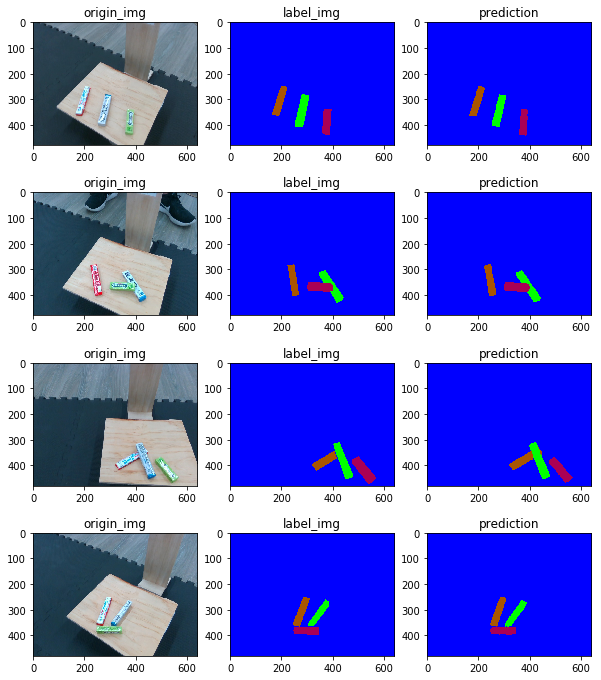

In [17]:
prediction("FCNs_mini_competition_batch10_epoch99_RMSprop_lr0.0001.pkl")

### HW: Plot three graphs: Training loss, class IOU curve, class F-score curve  

In [48]:
def draw_evaluation_curve(
    score_dir_path = score_dir, 
    f_score_filename="fscore_log.txt", 
    cls_iou_filename="cls_iou_log.txt", 
    loss_filename="loss_log.txt"):
    
    epoch = np.arange(0,100,1)
    color = ['red', 'green', 'blue']
    brand = ['doublemint', 'kinder', 'kusan']
    
    plt.figure()
    for i in range(3):
        plt.title("0410757_fscore")
        plt.plot(epoch, fscore_l[:,i], color = color[i], label = brand[i])
        plt.legend()
    plt.xlim(0,100)
    plt.figure()
    for i in range(3):
        plt.title("0410757_iou")
        plt.plot(epoch, iou_l[:,i], color = color[i], label = brand[i])
        plt.legend()
    plt.xlim(0,100)
    plt.figure()
    plt.title("0410757_loss")
    plt.plot(epoch, loss_l, color = 'black', label = 'loss')
    plt.legend()
    plt.xlim(0,100)

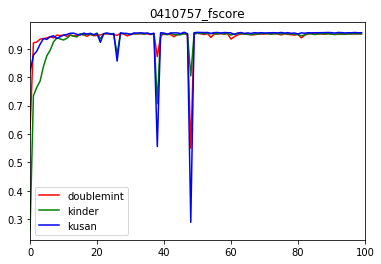

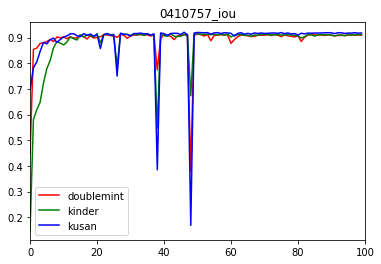

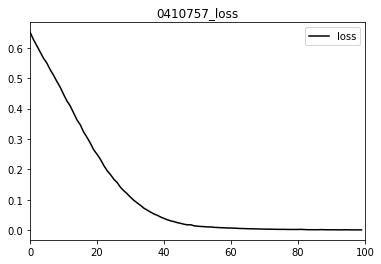

In [49]:
draw_evaluation_curve()

In [53]:
# print(loss_l)
# print(fscore_l)

In [75]:
def test(model_name, data_path):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    img        = cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
    origin     = img
    img        = img[:, :, ::-1]  # switch to BGR

    img = np.transpose(img, (2, 0, 1)) / 255.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    # convert to tensor
    img = img[np.newaxis,:]
    img = torch.from_numpy(img.copy()).float() 
    output = fcn_model(img)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    
    img = img.numpy()
    for i in range(N):
        plt.figure()
        origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
        plt.title("origin_img")
        plt.imshow(origin)
        plt.figure()
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

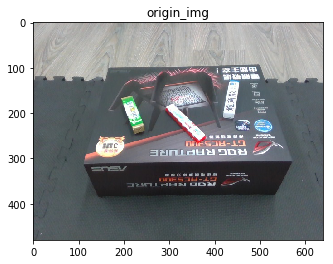

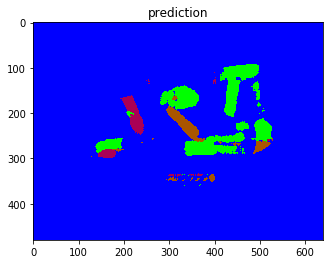

In [92]:
test("FCNs_mini_competition_batch10_epoch99_RMSprop_lr0.0001.pkl","data/test_log/frame-000015.jpg")